In [1]:
import argparse
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import itertools
import os
import importlib
from IPython.display import Image, display, HTML
import glob
import importlib
import sys
print(sys.version)

# my modules in $HOME/src/python
import plotutils as pu

3.7.5 (default, Nov 20 2019, 09:21:52) 
[GCC 9.2.1 20191008]


In [2]:
if pu.is_notebook():
    # this makes the notebook wider on a larger screen using %x of the display
    display(HTML("<style>.container { width:100% !important; }</style>"))
    # save this notebook as a raw python file as well please
    !jupyter nbconvert --to script ghex-jube-plot.ipynb
    
# Tell pandas to display more columns without wrapping in dataframe output
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

[NbConvertApp] Converting notebook ghex-jube-plot.ipynb to script
[NbConvertApp] Writing 4964 bytes to ghex-jube-plot.py


In [3]:
# use this to reload the plotutils library (and reset any global vars)
# if you modify the plotutils library - it must be reloaded
importlib.reload(pu)

<module 'plotutils' from '/home/biddisco/src/python/plotutils.py'>

In [4]:
machine_names = ['ault', 'daint', 'tave', 'jb-s76', 'pop-os']
machine_desc = {'ault'  :'Ault \n (AMD EPYC 7501@2GHz) \n 32x2-Cores (128 pu) \n 8 numa',
                'daint' :'Daint \n (Xeon E5-2695v4@2.10GHz) \n 18*2 Cores (72 pu) \n 2 numa',
                'tave'  :'Tave \n KNL-Xeon-Phi 7230@1.30GHz \n 64 Cores (256 pu) \n 1 numa',
                'jb-s76':'Laptop \n 4 Cores (8 pu) \n 1 numa',
                'pop-os':'Laptop \n i7-6700HQ@2.60GHz \n 4 Cores (8 pu) \n 1 numa'
                }

ault_scale   = (0.0, 2.0)
daint_scale  = (0.0, 2.0)
tave_scale   = (0.6, 2.0)
laptop_scale = (0.0, 1.5)

In [5]:
# -------------------------------------------------
# This will read a single CSV file into a dataframe
# -------------------------------------------------
def read_csv(name, column_names):
    print('Reading',name)
    data = pd.read_csv(
        name,
        names=column_names,
        header=None,
        skiprows=3,
        comment='#',
        sep='\s*\|\s*', # regex to skip whitespace and use comma separator
        engine='python',
        index_col=False,
        skipinitialspace=True)
    # Clean data : if less than 7 cols are not NaN, drop the row
    #data.dropna(thresh=7, inplace=True)
    #pu.title_print('File ' + name, data)
    return data

# -------------------------------------------------
# Loads several files and concats them into one dataframe
# -------------------------------------------------
def load_csv_files_in_dir(filenames, machine, info, column_names):
    data = pd.DataFrame()
    for filename in filenames :
        data = pd.concat([data, read_csv(filename, column_names)], sort=False)
    return data

# -------------------------------------------------
# read the jube generated files in a given dir
# -------------------------------------------------
def load_jube_files_in_dir(data_root, date_str, prefix='', hostname='none', info=''):
    ext          = '.dat'
    column_names = ['system', 'domain_size','gt_backend','transport','variant','taskspernode','domainthreads','ompthreads','nodes','colspersec','time']
    alldata      = pd.DataFrame()
    dirname      = os.path.join(data_root, date_str)
    for m in machine_names:
        filenames = glob.glob(os.path.join(dirname, m + '-*' + ext))
        #print('Calling load with hostname', m, dirname)
        data = load_csv_files_in_dir(filenames, m, info, column_names)
        data['date']     = date_str
        data['hostname'] = m        
        alldata = pd.concat([alldata, data], sort=False)
    pu.add_to_global_data(alldata, os.path.join(dirname, prefix))
    return alldata

In [6]:
def reset_data():
    pu.global_dataframe = pd.DataFrame(
        columns=['futures', 'launch', 'sync', 'exec', 'time', 'ftime', 'sched', 'numa', 'threads', 'info', 'date', 'hostname'])
    pu.global_dataframe.index.name = 'index'
    pu.global_datadict = {}

reset_data()

Reading /home/biddisco/benchmarking-results/ghex/2020-02-18/daint-result-gpu.dat
Total data loaded 96 lines

-------------------- 
 
--------------------
          date hostname     system  domain_size gt_backend transport variant  taskspernode  domainthreads  ompthreads  nodes    colspersec      time
0   2020-02-18    daint  daint_gpu        512.0       cuda       gcl     mpi           1.0            1.0         1.0    1.0  153422.00000   1.70865
1   2020-02-18    daint  daint_gpu        512.0       cuda       gcl     mpi           1.0            1.0         1.0    4.0  121379.50000   2.15971
2   2020-02-18    daint  daint_gpu        512.0       cuda       gcl     mpi           1.0            1.0         1.0   16.0  115979.37500   2.26026
3   2020-02-18    daint  daint_gpu        512.0       cuda       gcl     mpi           1.0            1.0         1.0   64.0  111086.56250   2.35982
4   2020-02-18    daint  daint_gpu        512.0       cuda       gcl     mpi          12.0           

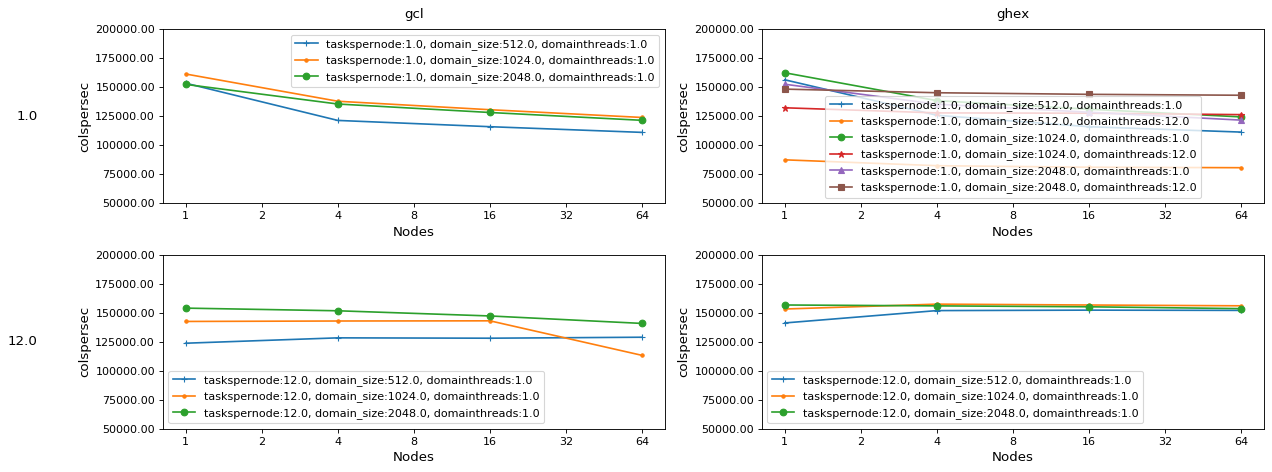

In [7]:
date_str = '2020-02-18'
data_root = '/home/biddisco/benchmarking-results/ghex/'
data = load_jube_files_in_dir(data_root, date_str, 'daint-', 'daint')
pu.title_print('', data)

#
# Weak scaling plot
#
columns, rows = ['transport'], ['taskspernode']
select        = { 'date':date_str, 'variant':'mpi'}
plotvars      = {'x':'nodes', 'y':'colspersec', 'series':['taskspernode', 'domain_size', 'domainthreads']}
xparams       = pu.axis(label='Nodes',  scale='log', base=2)
yparams       = pu.axis(label='colspersec', format=lambda v,pos: '{0:.2f}'.format(v), limits=(50000,200000), scale='linear', base=2)
cparams       = pu.rowcol(format=lambda t,v: str(v))
rparams       = pu.rowcol(format=lambda t,v: str(v))
fig = pu.plot_graph_series(data, rows, columns, select, plotvars, xparams, yparams, rparams=rparams, cparams=cparams, size=(8,3))

In [8]:
# show the graphs
if not pu.is_notebook():
    plt.show()